# Attention readout and visualisation

In [1]:
# this file uses the environment called attentionviz2

/home/ifender/miniconda3/envs/attentionviz2/bin/python


In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit import RDConfig
import os
import sys
#plotting
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import namedtuple
import torch
from IPython.display import SVG
from IPython.display import Image, display
import io
import numpy as np

In [2]:
#to import to get attention from model
from attention_readout import gather_attention
from constants import PREDICTION_MODEL_PATH

/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
2024-06-12 15:22:18 | INFO | fairseq.tasks.text_to_speech | Pl

## Functions

In [3]:
def clean_SMILES(SMILES_tok):
    """Removing structural tokens, hydrogens, and numbers from SMILES token input

    Args:
        SMILES_tok (_list_): List of SMILES_tokens for a given SMILES

    Returns:
        _list,list_: Processed SMILES_token list and list of positions in input tokens list that were kept
        (needed to distinguish which embeddings are relevant)
    """
    SMILES_tok_prep = list()
    struc_toks = r"()=:~1234567890#"
    posToKeep = list()
    pos = 0
    for i in range(len(SMILES_tok)):
        # when it's an H in the SMILES, ignore, cannot deal
        if SMILES_tok[i] != "H" and SMILES_tok[i] != "h" and not SMILES_tok[i].isdigit() and not SMILES_tok[i].isspace():
            if any(elem in struc_toks for elem in SMILES_tok[i]) == False:
                if SMILES_tok[i] != "-":
                    SMILES_tok_prep.append(SMILES_tok[i])
                    # keep pos where you keep SMILES token
                    posToKeep.append(pos)
        pos += 1
    assert(len(posToKeep) == (len(SMILES_tok_prep))
           ), f"Length of positions-to-keep-array ({len(posToKeep)}) and length of SMILES_tok_prep ({len(SMILES_tok_prep)}) are not the same"
    print("SMILES_tok: ", SMILES_tok)
    print("posToKeep: ", posToKeep)
    print("SMILES_tok_prep: ", SMILES_tok_prep)

    return SMILES_tok_prep, posToKeep


In [10]:

def cleanAndNormalizeAttention(attention_array,posToKeep,clean_smiles):
    # filter attention tensor according to posToKeep to only keep attention for non-hydrogen atoms
    filtered_attentions = attention_array[posToKeep]
    print(len(filtered_attentions))
    assert len(clean_smiles)==len(filtered_attentions), "Assert failed"
    # condense attention depending on method chosen
    mean_values = np.mean(filtered_attentions)
    min_val = np.min(filtered_attentions)
    max_val = np.max(filtered_attentions)
    normalized_means = (filtered_attentions - min_val) / (max_val - min_val)
    print("before normalisation: ",filtered_attentions)
    print("normalized means where all values fall between 0 and 1: ",normalized_means)
    return normalized_means



In [5]:
def drawMoleculeWithAttention(orig_smiles,clean_smiles,norm_attentions):

    # Generate a color map from 0-1 scaled to attentions
    min_val = norm_attentions.min()
    max_val = norm_attentions.max()
    print(f"Minimum and maximum attention values: {min_val}, {max_val}")
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

    mol = Chem.MolFromSmiles(orig_smiles)
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
    mol_with_style = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=False)

    # Set the drawing options
    opts = drawer.drawOptions()

    # Create a color map for the atoms
    atom_colors = {i: scalar_map.to_rgba(norm_attentions[i])[:-1] for i in range(mol.GetNumAtoms())}  # Remove alpha channel

    # Draw the molecule with colored atoms according to attention scores
    AllChem.Compute2DCoords(mol)
    d = rdMolDraw2D.MolDraw2DSVG(400, 400)
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=range(mol.GetNumAtoms()),
                                      highlightAtomColors=atom_colors)

    d.FinishDrawing()
    # get the SVG string
    svg = d.GetDrawingText()
    # fix the svg string and display it
    display(SVG(svg.replace('svg:','')))

    # Colorbar
    plt.figure(figsize=(4.5, 0.5))
    img = np.array([[min_val, max_val]])
    plt.imshow(img, cmap='viridis')
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    colba = plt.colorbar(cax=cax, orientation="horizontal")
    colba.set_label('Attention Score')
    plt.savefig("test.png")
    plt.show()

In [6]:
def colorAtomsByAttention(smiles):
    #tokenize, only atomwise supported
    smiles_tok = list(smiles)
    clean_smiles,posToKeep = clean_SMILES(smiles_tok)
    # get attention from model, only BART for now
    attention = gather_attention(smiles,
                 smiles_atom_path=PREDICTION_MODEL_PATH/"smiles_atom_isomers_bart"/"checkpoint_last.pt",
                 smiles_sentencepiece_path=PREDICTION_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")
    # remove attention on hydrogens, numbers, structural tokens and minmax normalize attention to values between 0 and 1
    norm_attention = cleanAndNormalizeAttention(attention,posToKeep,clean_smiles)
    # draw molecule with colored atoms according to attention scores
    drawMoleculeWithAttention(smiles,clean_smiles,norm_attention)

## Main

### Choose SMILES and get only the atoms from it

In [7]:
# get rid of structural topkens and hydrogens in SMILES
smiles="CC=CCOCC"
#only care about atomwise tokenisation
smiles_tok = list(smiles)
clean_smiles,posToKeep = clean_SMILES(smiles_tok)

SMILES_tok:  ['C', 'C', '=', 'C', 'C', 'O', 'C', 'C']
posToKeep:  [0, 1, 3, 4, 5, 6, 7]
SMILES_tok_prep:  ['C', 'C', 'C', 'C', 'O', 'C', 'C']


### Decide on the model to analyze and gather the attention for the previously chosen SMILES

In [8]:
attention = gather_attention(smiles,
                 smiles_atom_path=PREDICTION_MODEL_PATH/"smiles_atom_isomers_bart"/"checkpoint_last.pt",
                 smiles_sentencepiece_path=PREDICTION_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")


2024-06-12 15:22:36 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2024-06-12 15:22:36 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2024-06-12 15:22:36 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2024-06-12 15:22:38 | INFO | fairseq.models.bart.model | Regis

### Remove attention on structural tokens and hydrogens

In [9]:
norm_attention = cleanAndNormalizeAttention(attention,posToKeep,clean_smiles)

7
normalized means where all values fall between 0 and 1:  0.631425447834213


### Draw Molecule

Minimum and maximum attention values: 0.0, 1.0


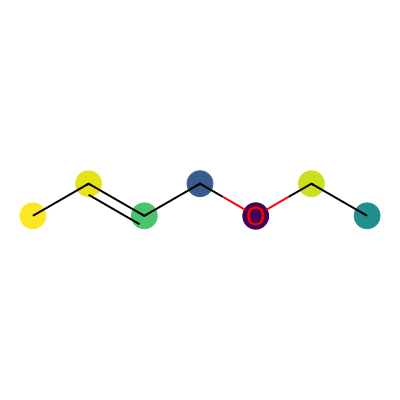

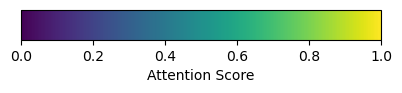

In [20]:
drawMoleculeWithAttention(smiles,clean_smiles,norm_attention)

## SMILES to look into:
### Looking into attention differences in symmetrical molecules:

1) c1cc2ccc3cccc4ccc(c1)c2c34 (Highly symmetrical (4 benzol rings))

2) O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl (Also very symmetrical, espc. Ns, Cls and Os in similar positions interesting to compare attention)

3) c1ccc(-c2ccc(-c3ccccc3)cc2)cc1 (three benzol rings in a chain)

4) c1ccc2c(c1)sc1ccccc12 (2 benzol rings, one five-ring )

### Looking into differences in hydrophobicity:

5) C1=CC=CC=C1 (Benzol, Solubility in water: 1.84 g/L (30 °C) (see: https://en.wikipedia.org/wiki/Benzene))

6) CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O (Aspirin, Solubility in water 3g/L (see: https://en.wikipedia.org/wiki/Aspirin))

7) C1=CC(=CC=C1C(=O)O)O (PHBA (found in: https://www.sciencedirect.com/science/article/pii/S095965262030247X#fig1), Solubility in Water 5g/L at 25 °C (https://pubchem.ncbi.nlm.nih.gov/compound/135#section=Melting-Point))

8) CCCCOC(=O)C1=CC=C(C=C1)N (Butyl 4-aminobenzoate (see: https://pubchem.ncbi.nlm.nih.gov/compound/2482#section=Melting-Point), Solubility in Water: 0.14g/L (no temperature stated))